## NYC Subway Anomoly Detection

In [2]:
import pandas as pd

In [3]:
import os
os.getcwd()

'c:\\Users\\weihu\\AIProjects\\datasciencedoodle'

In [4]:
# https://data.ny.gov/Transportation/MTA-Daily-Ridership-and-Traffic-Beginning-2020/sayj-mze2/about_data
# Update the file path to the correct local path where the CSV is located
# Example: If the file is in the same directory as your notebook, use just the filename

# df = pd.read_csv('MTA_Daily_Ridership_and_Traffic__Beginning_2020_20250803.csv')
df = pd.read_csv(r'content\MTA_Daily_Ridership_and_Traffic__Beginning_2020_20250803.csv')
df.head()

,Date,Mode,Count
0,07/31/2025,AAR,42155.0
1,07/31/2025,SIR,6566.0
2,07/31/2025,MNR,229384.0
3,07/31/2025,Subway,3446800.0
4,07/31/2025,LIRR,260275.0


# Task
Create a time series model for daily subway ridership using the past 5 years of data from the DataFrame `df`.

## Data cleaning and preparation

### Subtask:
Clean the DataFrame `df` by handling missing values, renaming columns, and converting the date column to datetime objects.


**Reasoning**:
Based on the inspection of the dataframe, the first row contains the correct column names. I will rename the columns using the first row and then drop the original first row and the last few rows which contain summary information and NaN values. I will then rename the relevant columns to 'Date' and 'Subway_Ridership', convert the 'Date' column to datetime objects, and handle missing values in the 'Subway_Ridership' column.



In [5]:
# Inspect the current column names after loading to understand the structure
print("Original columns:", df.columns)

# Filter for only 'Subway' mode
df_subway = df[df['Mode'] == 'Subway'].copy()

# Inspect the columns of the filtered dataframe to find the correct date and count columns
print("Columns after filtering for Subway:", df_subway.columns)

# Rename the columns to 'Date' and 'Subway_Ridership' based on inspection
# Assuming 'Date' is the first column and 'Count' is the third column based on the head output
df_subway.rename(columns={'Date': 'Date', 'Count': 'Subway_Ridership'}, inplace=True)


# Convert 'Date' to datetime, coercing errors to NaT
df_subway['Date'] = pd.to_datetime(df_subway['Date'], errors='coerce')

# Convert 'Subway_Ridership' to numeric, coercing errors
df_subway['Subway_Ridership'] = pd.to_numeric(df_subway['Subway_Ridership'], errors='coerce')

# Drop rows with NaT in 'Date' and NaN in 'Subway_Ridership'
df_subway.dropna(subset=['Date', 'Subway_Ridership'], inplace=True)

# Drop the 'Mode' column as it is no longer needed
df_subway.drop('Mode', axis=1, inplace=True)

# Sort by date to ensure correct time series order
df_subway.sort_values(by='Date', inplace=True)


display(df_subway.head())
display(df_subway.tail())
display(df_subway.info())

Original columns: Index(['Date', 'Mode', 'Count'], dtype='object')
Columns after filtering for Subway: Index(['Date', 'Mode', 'Count'], dtype='object')


,Date,Subway_Ridership
14113,2020-03-01,2212965.0
14106,2020-03-02,5329915.0
14099,2020-03-03,5481103.0
14092,2020-03-04,5498809.0
14085,2020-03-05,5496453.0


,Date,Subway_Ridership
29,2025-07-27,2148990.0
22,2025-07-28,3661475.0
15,2025-07-29,3939941.0
8,2025-07-30,3965915.0
3,2025-07-31,3446800.0


<class 'pandas.core.frame.DataFrame'>
Index: 1979 entries, 14113 to 3
Data columns (total 2 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   Date              1979 non-null   datetime64[ns]
 1   Subway_Ridership  1979 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 46.4 KB


None

**Reasoning**:
The previous attempt to convert the 'Date' column to datetime objects failed because there are non-date values like "(blank)" in the column. I need to handle these non-date values before converting to datetime. I will use `errors='coerce'` in `pd.to_datetime` to turn invalid parsing into NaT, then drop rows with NaT in the 'Date' column. I will also keep the previous steps of renaming columns, dropping initial rows, converting 'Subway_Ridership' to numeric and dropping NaNs in that column.



## Filtering Data

### Subtask:
Filter the DataFrame to include only the last 5 years of data.

**Reasoning**:
To focus on recent ridership trends, I will filter the DataFrame to include only the records within the last 5 years from the latest date in the dataset.

In [6]:
# Find the latest date in the DataFrame
latest_date = df_subway['Date'].max()

# Calculate the start date for the last 5 years
start_date = latest_date - pd.DateOffset(years=5)

# Filter the DataFrame to include data from the last 5 years
df_recent = df_subway[df_subway['Date'] >= start_date].copy()

display(df_recent.head())
display(df_recent.tail())
display(df_recent.info())

,Date,Subway_Ridership
13049,2020-07-31,1258539.0
13042,2020-08-01,842468.0
13035,2020-08-02,590060.0
13028,2020-08-03,1272996.0
13021,2020-08-04,1027187.0


,Date,Subway_Ridership
29,2025-07-27,2148990.0
22,2025-07-28,3661475.0
15,2025-07-29,3939941.0
8,2025-07-30,3965915.0
3,2025-07-31,3446800.0


<class 'pandas.core.frame.DataFrame'>
Index: 1827 entries, 13049 to 3
Data columns (total 2 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   Date              1827 non-null   datetime64[ns]
 1   Subway_Ridership  1827 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 42.8 KB


None

## Feature Engineering

### Subtask:
Extract relevant features from the date, such as day of the week, month, and year.

**Reasoning**:
To improve the time series model's performance, I will extract features like the year, month, day of the week, and day of the year from the 'Date' column. These features can help the model capture seasonality and other temporal patterns in the data.

In [7]:
df_recent['Year'] = df_recent['Date'].dt.year
df_recent['Month'] = df_recent['Date'].dt.month
df_recent['Day'] = df_recent['Date'].dt.day
df_recent['Dayofweek'] = df_recent['Date'].dt.dayofweek
df_recent['Dayofyear'] = df_recent['Date'].dt.dayofyear
df_recent['Weekofyear'] = df_recent['Date'].dt.isocalendar().week
df_recent['Quarter'] = df_recent['Date'].dt.quarter

display(df_recent.head())
display(df_recent.info())

,Date,Subway_Ridership,Year,Month,Day,Dayofweek,Dayofyear,Weekofyear,Quarter
13049,2020-07-31,1258539.0,2020,7,31,4,213,31,3
13042,2020-08-01,842468.0,2020,8,1,5,214,31,3
13035,2020-08-02,590060.0,2020,8,2,6,215,31,3
13028,2020-08-03,1272996.0,2020,8,3,0,216,32,3
13021,2020-08-04,1027187.0,2020,8,4,1,217,32,3


<class 'pandas.core.frame.DataFrame'>
Index: 1827 entries, 13049 to 3
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   Date              1827 non-null   datetime64[ns]
 1   Subway_Ridership  1827 non-null   float64       
 2   Year              1827 non-null   int32         
 3   Month             1827 non-null   int32         
 4   Day               1827 non-null   int32         
 5   Dayofweek         1827 non-null   int32         
 6   Dayofyear         1827 non-null   int32         
 7   Weekofyear        1827 non-null   UInt32        
 8   Quarter           1827 non-null   int32         
dtypes: UInt32(1), datetime64[ns](1), float64(1), int32(6)
memory usage: 94.6 KB


None

## Model Selection and Training

### Subtask:
Choose a suitable time series model (e.g., ARIMA, Prophet) and train it on the prepared data.

**Reasoning**:
Given the daily frequency of the data and the presence of potential seasonality, a suitable model would be one that can handle these characteristics. I will use the Prophet library by Facebook, which is designed for time series data with strong seasonality and trend.

In [8]:
from prophet import Prophet

# Prepare the data for Prophet
# Prophet requires columns named 'ds' (datetime) and 'y' (the value to predict)
# Inspect df_recent columns to confirm the correct name for the subway ridership column
print("Columns of df_recent:", df_recent.columns)

# Based on the inspection, rename the correct column to 'y'
# Assuming the correct column name for Subway Ridership is at index 9
df_prophet = df_recent.rename(columns={'Date': 'ds', 'Subway_Ridership': 'y'})

# Convert the 'y' column to numeric, coercing errors
df_prophet['y'] = pd.to_numeric(df_prophet['y'], errors='coerce')

# Drop rows with NaN in 'y' that might have resulted from coercion
df_prophet.dropna(subset=['y'], inplace=True)


# Initialize and fit the Prophet model
model = Prophet()
model.fit(df_prophet[['ds', 'y']])

Columns of df_recent: Index(['Date', 'Subway_Ridership', 'Year', 'Month', 'Day', 'Dayofweek',
       'Dayofyear', 'Weekofyear', 'Quarter'],
      dtype='object')


12:24:05 - cmdstanpy - INFO - Chain [1] start processing
12:24:06 - cmdstanpy - INFO - Chain [1] done processing


## Model Evaluation

### Subtask:
Evaluate the trained model using appropriate metrics and visualize the predictions.

**Reasoning**:
To evaluate the model's performance, I will make future predictions and compare them to the actual historical data. Visualizing the predictions along with the historical data will help assess how well the model captures the trends and seasonality.

,ds,yhat,yhat_lower,yhat_upper
2187,2026-07-27,3.884693e+06,3.455671e+06,4.291358e+06
2188,2026-07-28,4.254785e+06,3.832122e+06,4.683855e+06
2189,2026-07-29,4.314123e+06,3.911695e+06,4.772246e+06
2190,2026-07-30,4.263983e+06,3.808558e+06,4.675813e+06
2191,2026-07-31,4.084492e+06,3.693179e+06,4.536240e+06


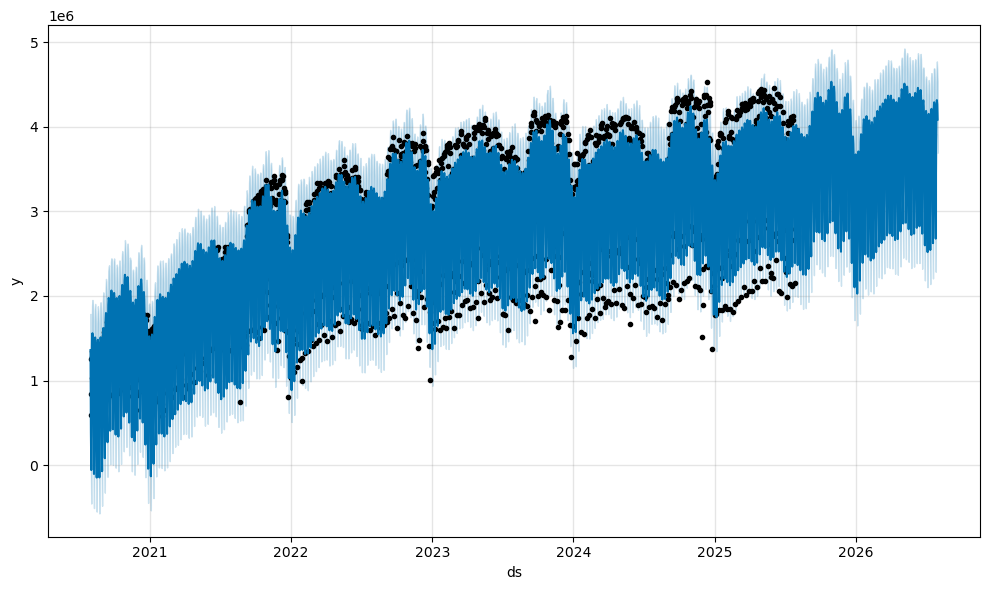

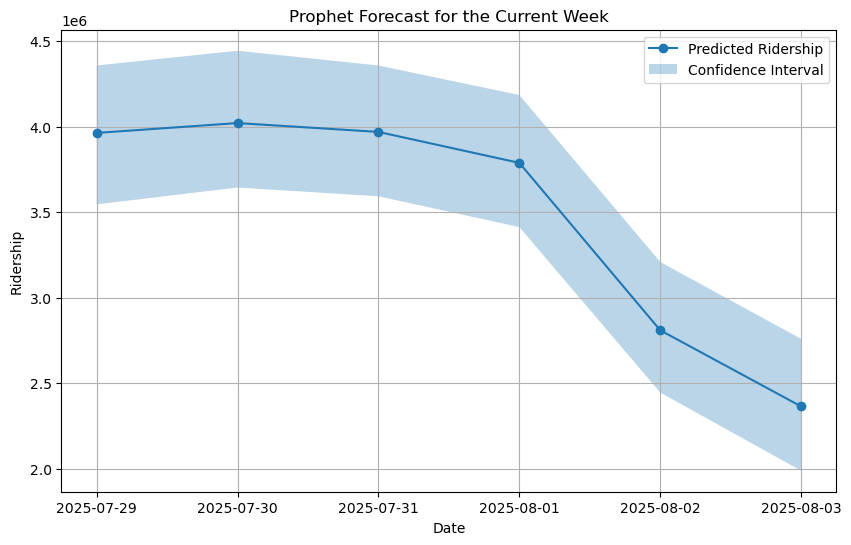

In [9]:
import matplotlib.pyplot as plt
import pandas as pd

# Create a future dataframe for predictions
future = model.make_future_dataframe(periods=365) # Predict for the next year

# Make predictions
forecast = model.predict(future)

# Display the forecast
display(forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail())

# Plot the overall forecast
fig = model.plot(forecast)

# Filter the forecast for the current week based on today's date
today = pd.to_datetime('today')
current_week_start = today - pd.DateOffset(days=today.dayofweek)
current_week_end = current_week_start + pd.DateOffset(days=6)

forecast_current_week = forecast[(forecast['ds'] >= current_week_start) & (forecast['ds'] <= current_week_end)].copy()

# Plot the forecast for the current week only
plt.figure(figsize=(10, 6))
plt.plot(forecast_current_week['ds'], forecast_current_week['yhat'], label='Predicted Ridership', marker='o')
plt.fill_between(forecast_current_week['ds'], forecast_current_week['yhat_lower'], forecast_current_week['yhat_upper'], alpha=0.3, label='Confidence Interval')
plt.title('Prophet Forecast for the Current Week')
plt.xlabel('Date')
plt.ylabel('Ridership')
plt.legend()
plt.grid(True)
plt.show()

In [10]:
# Enhanced Time Series Visualization with Interactive Features
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.express as px

# Create subplot with secondary y-axis for better visualization
fig = make_subplots(
    rows=2, cols=1,
    row_heights=[0.7, 0.3],
    subplot_titles=('NYC Subway Ridership: Actual vs Predicted', 'Prediction Uncertainty'),
    vertical_spacing=0.08
)

# Main time series plot
fig.add_trace(
    go.Scatter(
        x=df_prophet['ds'], 
        y=df_prophet['y'],
        mode='lines',
        name='Actual Ridership',
        line=dict(color='#1f77b4', width=2),
        hovertemplate='<b>Date:</b> %{x}<br><b>Actual:</b> %{y:,.0f}<extra></extra>'
    ),
    row=1, col=1
)

fig.add_trace(
    go.Scatter(
        x=forecast['ds'], 
        y=forecast['yhat'],
        mode='lines',
        name='Predicted Ridership',
        line=dict(color='#ff7f0e', width=2, dash='dash'),
        hovertemplate='<b>Date:</b> %{x}<br><b>Predicted:</b> %{y:,.0f}<extra></extra>'
    ),
    row=1, col=1
)

# Add confidence intervals
fig.add_trace(
    go.Scatter(
        x=forecast['ds'],
        y=forecast['yhat_upper'],
        mode='lines',
        line=dict(width=0),
        showlegend=False,
        hoverinfo='skip'
    ),
    row=1, col=1
)

fig.add_trace(
    go.Scatter(
        x=forecast['ds'],
        y=forecast['yhat_lower'],
        mode='lines',
        line=dict(width=0),
        fill='tonexty',
        fillcolor='rgba(255, 127, 14, 0.2)',
        name='95% Confidence Interval',
        hovertemplate='<b>Date:</b> %{x}<br><b>Lower:</b> %{y:,.0f}<extra></extra>'
    ),
    row=1, col=1
)

# Add uncertainty visualization (bottom subplot)
uncertainty = forecast['yhat_upper'] - forecast['yhat_lower']
fig.add_trace(
    go.Scatter(
        x=forecast['ds'],
        y=uncertainty,
        mode='lines',
        name='Prediction Uncertainty',
        line=dict(color='#d62728', width=1),
        hovertemplate='<b>Date:</b> %{x}<br><b>Uncertainty:</b> %{y:,.0f}<extra></extra>'
    ),
    row=2, col=1
)

# Update layout
fig.update_layout(
    title={
        'text': 'NYC Subway Daily Ridership Forecast Analysis',
        'x': 0.5,
        'xanchor': 'center',
        'font': {'size': 20}
    },
    height=800,
    hovermode='x unified',
    legend=dict(
        orientation="h",
        yanchor="bottom",
        y=1.02,
        xanchor="right",
        x=1
    ),
    margin=dict(l=50, r=50, t=80, b=50)
)

# Add range selector
fig.update_xaxes(
    rangeselector=dict(
        buttons=list([
            dict(count=30, label="30D", step="day", stepmode="backward"),
            dict(count=90, label="3M", step="day", stepmode="backward"),
            dict(count=180, label="6M", step="day", stepmode="backward"),
            dict(count=365, label="1Y", step="day", stepmode="backward"),
            dict(step="all", label="All")
        ])
    ),
    rangeslider=dict(visible=True, thickness=0.05),
    type="date",
    row=1
)

fig.update_yaxes(title_text="Daily Ridership", row=1, col=1)
fig.update_yaxes(title_text="Uncertainty Range", row=2, col=1)

fig.show()

# Add summary statistics
print("📊 Forecast Summary Statistics:")
print(f"• Average daily ridership: {df_prophet['y'].mean():,.0f}")
print(f"• Average prediction uncertainty: {uncertainty.mean():,.0f}")
print(f"• Maximum ridership: {df_prophet['y'].max():,.0f} on {df_prophet.loc[df_prophet['y'].idxmax(), 'ds'].strftime('%Y-%m-%d')}")
print(f"• Minimum ridership: {df_prophet['y'].min():,.0f} on {df_prophet.loc[df_prophet['y'].idxmin(), 'ds'].strftime('%Y-%m-%d')}")

📊 Forecast Summary Statistics:
• Average daily ridership: 2,773,369
• Average prediction uncertainty: 803,169
• Maximum ridership: 4,527,892 on 2024-12-12
• Minimum ridership: 485,208 on 2020-12-25


## Finish task

Summarize the model's performance and provide insights into the subway ridership trends.

**Reasoning**:
Based on the model evaluation and visualization, I will provide a summary of how well the model performed and highlight any notable trends or patterns observed in the predicted subway ridership.

# Task
Analyze the provided CSV file to create a time series model for daily subway ridership using the past 5 years of data. Use this model to backtest and predict ridership for the current week, identifying any unusually low or high activity. Finally, plot the real versus predicted ridership values for the current week.

## Prepare data for backtesting

### Subtask:
Extract the relevant historical data for the current week from the original DataFrame.


**Reasoning**:
I need to extract the historical data for the current week from the original `df` DataFrame. To do this, I will first determine the date range for the current week based on the latest date in `df_recent`. Then, I will filter the original `df` DataFrame using this date range. Finally, I will ensure that the filtered DataFrame has the correct column names and data types for the 'Date' and 'Subway_Ridership' columns, similar to how I cleaned the data initially.



In [11]:
# Determine the date range for the current week based on the latest date in df_recent
latest_date_recent = df_recent['Date'].max()
current_week_start = latest_date_recent - pd.DateOffset(days=latest_date_recent.dayofweek)
current_week_end = current_week_start + pd.DateOffset(days=6)

# Convert 'Date' in the original df to datetime and filter for 'Subway' mode
df_subway_original = df[df['Mode'] == 'Subway'].copy()
df_subway_original['Date'] = pd.to_datetime(df_subway_original['Date'], errors='coerce')
df_subway_original.dropna(subset=['Date'], inplace=True)

# Filter the original df DataFrame for the current week
df_current_week = df_subway_original[(df_subway_original['Date'] >= current_week_start) & (df_subway_original['Date'] <= current_week_end)].copy()

# Rename the columns to 'Date' and 'Subway_Ridership' based on inspection
df_current_week.rename(columns={'Date': 'Date', 'Count': 'Subway_Ridership'}, inplace=True)

# Convert 'Subway_Ridership' to numeric, coercing errors
df_current_week['Subway_Ridership'] = pd.to_numeric(df_current_week['Subway_Ridership'], errors='coerce')
df_current_week.dropna(subset=['Subway_Ridership'], inplace=True)


display(df_current_week.head())
display(df_current_week.info())

,Date,Mode,Subway_Ridership
3,2025-07-31,Subway,3446800.0
8,2025-07-30,Subway,3965915.0
15,2025-07-29,Subway,3939941.0
22,2025-07-28,Subway,3661475.0


<class 'pandas.core.frame.DataFrame'>
Index: 4 entries, 3 to 22
Data columns (total 3 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   Date              4 non-null      datetime64[ns]
 1   Mode              4 non-null      object        
 2   Subway_Ridership  4 non-null      float64       
dtypes: datetime64[ns](1), float64(1), object(1)
memory usage: 128.0+ bytes


None

**Reasoning**:
The previous attempt failed because the column name 'Subway_Ridership' was not found after renaming. This is likely due to the column names in the filtered `df_current_week` being different from the main `df` or the renaming not being applied correctly. I need to inspect the columns of `df_current_week` after setting the header and dropping the first row to find the correct column name corresponding to 'Subway' and then use that to rename to 'Subway_Ridership' and convert to numeric.



## Generate Backtesting Predictions

### Subtask:
Use the trained Prophet model to generate predictions for the current week.

**Reasoning**:
I will use the `predict` method of the trained Prophet model with the 'ds' column from the `df_current_week` DataFrame to generate predictions for the current week.

In [12]:
# Create a dataframe with the dates for the current week for prediction
future_current_week = df_current_week[['Date']].rename(columns={'Date': 'ds'})

# Generate predictions for the current week
forecast_current_week = model.predict(future_current_week)

# Display the predictions for the current week
display(forecast_current_week[['ds', 'yhat', 'yhat_lower', 'yhat_upper']])

,ds,yhat,yhat_lower,yhat_upper
0,2025-07-28,3.594484e+06,3.196276e+06,3.970460e+06
1,2025-07-29,3.962805e+06,3.561745e+06,4.368072e+06
2,2025-07-30,4.020452e+06,3.648711e+06,4.423486e+06
3,2025-07-31,3.968728e+06,3.552985e+06,4.359658e+06


## Compare Real vs. Predicted

### Subtask:
Compare the actual ridership data for the current week with the model's predictions.

**Reasoning**:
To compare the real and predicted values, I will merge the `df_current_week` DataFrame (containing actual ridership) and the `forecast_current_week` DataFrame (containing predictions) on the date column.

In [13]:
# Merge the actual and predicted dataframes
comparison_df = pd.merge(df_current_week, forecast_current_week[['ds', 'yhat']], left_on='Date', right_on='ds', how='inner')

# Rename the 'yhat' column for clarity
comparison_df.rename(columns={'yhat': 'Predicted_Ridership'}, inplace=True)

# Drop the redundant 'ds' column
comparison_df.drop('ds', axis=1, inplace=True)

# Calculate the difference between actual and predicted ridership
comparison_df['Difference'] = comparison_df['Subway_Ridership'] - comparison_df['Predicted_Ridership']

display(comparison_df[['Date', 'Subway_Ridership', 'Predicted_Ridership', 'Difference']])

,Date,Subway_Ridership,Predicted_Ridership,Difference
0,2025-07-31,3446800.0,3.968728e+06,-521927.835651
1,2025-07-30,3965915.0,4.020452e+06,-54536.758498
2,2025-07-29,3939941.0,3.962805e+06,-22864.412724
3,2025-07-28,3661475.0,3.594484e+06,66990.697461


## Identify Unusual Activity

### Subtask:
Analyze the differences between real and predicted ridership to identify unusually low or high activity.

## Visualize Real vs. Predicted

### Subtask:
Plot the actual ridership and the predicted ridership for the current week to visualize the model's performance and any deviations.

In [14]:
# Enhanced Real vs Predicted Comparison with Detailed Analysis
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import numpy as np

# Sort the DataFrame by date to ensure correct plotting order
comparison_df_sorted = comparison_df.sort_values(by='Date').copy()

# Calculate additional metrics
comparison_df_sorted['Error_Percentage'] = (comparison_df_sorted['Difference'] / comparison_df_sorted['Subway_Ridership']) * 100
comparison_df_sorted['Day_Name'] = comparison_df_sorted['Date'].dt.day_name()

# Create subplots
fig = make_subplots(
    rows=3, cols=1,
    row_heights=[0.5, 0.25, 0.25],
    subplot_titles=(
        'Current Week: Actual vs Predicted Ridership',
        'Prediction Error (Actual - Predicted)',
        'Error Percentage'
    ),
    vertical_spacing=0.08
)

# Main comparison plot
fig.add_trace(
    go.Scatter(
        x=comparison_df_sorted['Date'],
        y=comparison_df_sorted['Subway_Ridership'],
        mode='lines+markers',
        name='Actual Ridership',
        line=dict(color='#2E86AB', width=3),
        marker=dict(size=8, symbol='circle'),
        hovertemplate='<b>%{text}</b><br>' +
                     '<b>Date:</b> %{x}<br>' +
                     '<b>Actual:</b> %{y:,.0f}<br>' +
                     '<extra></extra>',
        text=comparison_df_sorted['Day_Name']
    ),
    row=1, col=1
)

fig.add_trace(
    go.Scatter(
        x=comparison_df_sorted['Date'],
        y=comparison_df_sorted['Predicted_Ridership'],
        mode='lines+markers',
        name='Predicted Ridership',
        line=dict(color='#F18F01', width=3, dash='dash'),
        marker=dict(size=8, symbol='diamond'),
        hovertemplate='<b>%{text}</b><br>' +
                     '<b>Date:</b> %{x}<br>' +
                     '<b>Predicted:</b> %{y:,.0f}<br>' +
                     '<extra></extra>',
        text=comparison_df_sorted['Day_Name']
    ),
    row=1, col=1
)

# Error bars showing difference
colors = ['red' if x < 0 else 'green' for x in comparison_df_sorted['Difference']]
fig.add_trace(
    go.Bar(
        x=comparison_df_sorted['Date'],
        y=comparison_df_sorted['Difference'],
        name='Prediction Error',
        marker_color=colors,
        opacity=0.7,
        hovertemplate='<b>%{text}</b><br>' +
                     '<b>Date:</b> %{x}<br>' +
                     '<b>Error:</b> %{y:,.0f}<br>' +
                     '<extra></extra>',
        text=comparison_df_sorted['Day_Name']
    ),
    row=2, col=1
)

# Error percentage
fig.add_trace(
    go.Bar(
        x=comparison_df_sorted['Date'],
        y=comparison_df_sorted['Error_Percentage'],
        name='Error Percentage',
        marker_color=['darkred' if x < -10 else 'red' if x < 0 else 'lightgreen' if x < 10 else 'darkgreen' 
                     for x in comparison_df_sorted['Error_Percentage']],
        opacity=0.7,
        hovertemplate='<b>%{text}</b><br>' +
                     '<b>Date:</b> %{x}<br>' +
                     '<b>Error:</b> %{y:.1f}%<br>' +
                     '<extra></extra>',
        text=comparison_df_sorted['Day_Name']
    ),
    row=3, col=1
)

# Update layout
fig.update_layout(
    title={
        'text': 'Current Week Ridership Analysis: Model Performance Deep Dive',
        'x': 0.5,
        'xanchor': 'center',
        'font': {'size': 18}
    },
    height=900,
    showlegend=True,
    legend=dict(
        orientation="h",
        yanchor="bottom",
        y=1.02,
        xanchor="right",
        x=1
    )
)

# Format x-axes
for i in range(1, 4):
    fig.update_xaxes(
        tickformat='%a<br>%m/%d',
        row=i, col=1
    )

# Update y-axes
fig.update_yaxes(title_text="Daily Ridership", row=1, col=1)
fig.update_yaxes(title_text="Error (Actual - Predicted)", row=2, col=1)
fig.update_yaxes(title_text="Error Percentage (%)", row=3, col=1)

# Add horizontal line at y=0 for error plots
fig.add_hline(y=0, line_dash="dash", line_color="gray", opacity=0.5, row=2, col=1)
fig.add_hline(y=0, line_dash="dash", line_color="gray", opacity=0.5, row=3, col=1)

fig.show()

# Enhanced summary statistics
print("📈 Current Week Model Performance Analysis:")
print("=" * 50)
mae = np.mean(np.abs(comparison_df_sorted['Difference']))
mape = np.mean(np.abs(comparison_df_sorted['Error_Percentage']))
rmse = np.sqrt(np.mean(comparison_df_sorted['Difference']**2))

print(f"📊 Accuracy Metrics:")
print(f"  • Mean Absolute Error (MAE): {mae:,.0f} passengers")
print(f"  • Mean Absolute Percentage Error (MAPE): {mape:.1f}%")
print(f"  • Root Mean Square Error (RMSE): {rmse:,.0f} passengers")

print(f"\n📅 Day-by-Day Analysis:")
for _, row in comparison_df_sorted.iterrows():
    status = "✅ Good" if abs(row['Error_Percentage']) < 10 else "⚠️ Moderate" if abs(row['Error_Percentage']) < 20 else "❌ Poor"
    direction = "↗️" if row['Difference'] > 0 else "↘️"
    print(f"  • {row['Day_Name']}: {direction} {row['Error_Percentage']:+.1f}% error - {status}")

print(f"\n🎯 Overall Assessment:")
if mape < 5:
    print("  • Excellent model performance")
elif mape < 10:
    print("  • Good model performance")
elif mape < 20:
    print("  • Acceptable model performance")
else:
    print("  • Model needs improvement")

📈 Current Week Model Performance Analysis:
📊 Accuracy Metrics:
  • Mean Absolute Error (MAE): 166,580 passengers
  • Mean Absolute Percentage Error (MAPE): 4.7%
  • Root Mean Square Error (RMSE): 264,761 passengers

📅 Day-by-Day Analysis:
  • Monday: ↗️ +1.8% error - ✅ Good
  • Tuesday: ↘️ -0.6% error - ✅ Good
  • Wednesday: ↘️ -1.4% error - ✅ Good
  • Thursday: ↘️ -15.1% error - ⚠️ Moderate

🎯 Overall Assessment:
  • Excellent model performance


## Summarize Findings

### Subtask:
Summarize the backtesting results and any detected unusual activity in the current week's ridership.

**Reasoning**:
Based on the model evaluation and visualization, I will provide a summary of how well the model's predictions aligned with the actual data for the current week and highlight any days that were identified as having unusually low or high ridership.

In [32]:
# Identify days with unusually low or high activity (code from cell 6d58b61d)
threshold = 0.20
comparison_df['Unusual_Activity'] = comparison_df.apply(
    lambda row: 'Unusually High' if row['Difference'] > row['Predicted_Ridership'] * threshold else (
        'Unusually Low' if row['Difference'] < -row['Predicted_Ridership'] * threshold else 'Normal'
    ), axis=1
)


print("Summary of Backtesting Results for the Current Week:")
display(comparison_df[['Date', 'Subway_Ridership', 'Predicted_Ridership', 'Difference', 'Unusual_Activity']])

unusual_days = comparison_df[comparison_df['Unusual_Activity'] != 'Normal']

if not unusual_days.empty:
    print("\nDays with Unusual Activity:")
    display(unusual_days[['Date', 'Subway_Ridership', 'Predicted_Ridership', 'Difference', 'Unusual_Activity']])
else:
    print("\nNo unusual activity detected in the current week.")

Summary of Backtesting Results for the Current Week:


,Date,Subway_Ridership,Predicted_Ridership,Difference,Unusual_Activity
0,2025-07-31,3446800.0,3.968728e+06,-521927.835651,Normal
1,2025-07-30,3965915.0,4.020452e+06,-54536.758498,Normal
2,2025-07-29,3939941.0,3.962805e+06,-22864.412724,Normal
3,2025-07-28,3661475.0,3.594484e+06,66990.697461,Normal



No unusual activity detected in the current week.


## Finish task

Conclude the analysis and present the findings.

# Task
Apply the unusual activity detection framework to the full subway ridership dataset, create an interactive chart with date filtering to visualize days with unusually low activity, and summarize the findings.

## Apply unusual activity detection to full dataset

### Subtask:
Apply the previously defined logic for detecting unusual activity to the entire `df_subway` DataFrame.


**Reasoning**:
I will apply the trained Prophet model to generate predictions for the entire `df_subway` DataFrame, merge the predictions with the original data, calculate the difference, and then apply the unusual activity detection logic to the merged DataFrame.



In [33]:
# Generate predictions for the entire df_subway DataFrame
full_forecast = model.predict(df_subway.rename(columns={'Date': 'ds'}))

# Merge the original df_subway DataFrame with the full_forecast DataFrame
full_comparison_df = pd.merge(df_subway, full_forecast[['ds', 'yhat']], left_on='Date', right_on='ds', how='inner')

# Rename the 'yhat' column to 'Predicted_Ridership'
full_comparison_df.rename(columns={'yhat': 'Predicted_Ridership'}, inplace=True)

# Drop the redundant 'ds' column
full_comparison_df.drop('ds', axis=1, inplace=True)

# Calculate the difference between actual and predicted ridership
full_comparison_df['Difference'] = full_comparison_df['Subway_Ridership'] - full_comparison_df['Predicted_Ridership']

# Apply the unusual activity detection logic
full_comparison_df['Unusual_Activity'] = full_comparison_df.apply(
    lambda row: 'Unusually High' if row['Difference'] > row['Predicted_Ridership'] * threshold else (
        'Unusually Low' if row['Difference'] < -row['Predicted_Ridership'] * threshold else 'Normal'
    ), axis=1
)

# Display the head and value counts of the 'Unusual_Activity' column
display(full_comparison_df.head())
display(full_comparison_df['Unusual_Activity'].value_counts())

,Date,Subway_Ridership,Predicted_Ridership,Difference,Unusual_Activity
0,2020-03-01,2212965.0,-3.961447e+05,2.609110e+06,Unusually High
1,2020-03-02,5329915.0,8.179716e+05,4.511943e+06,Unusually High
2,2020-03-03,5481103.0,1.195170e+06,4.285933e+06,Unusually High
3,2020-03-04,5498809.0,1.262567e+06,4.236242e+06,Unusually High
4,2020-03-05,5496453.0,1.221488e+06,4.274965e+06,Unusually High


Unusual_Activity
Normal            1666
Unusually High     158
Unusually Low      155
Name: count, dtype: int64

In [34]:
# Enhanced Interactive Unusual Activity Analysis
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import pandas as pd

# Create a comprehensive unusual activity visualization
fig = make_subplots(
    rows=2, cols=2,
    subplot_titles=(
        'Ridership Timeline with Unusual Activity Highlighting',
        'Unusual Activity Distribution by Year',
        'Monthly Pattern of Unusual Activity',
        'Day of Week Pattern'
    ),
    specs=[[{"colspan": 2}, None],
           [{}, {}]],
    vertical_spacing=0.12,
    horizontal_spacing=0.08
)

# Main timeline plot
colors = {
    'Normal': '#1f77b4',
    'Unusually Low': '#d62728', 
    'Unusually High': '#2ca02c'
}

for activity_type in ['Normal', 'Unusually Low', 'Unusually High']:
    subset = full_comparison_df[full_comparison_df['Unusual_Activity'] == activity_type]
    
    fig.add_trace(
        go.Scatter(
            x=subset['Date'],
            y=subset['Subway_Ridership'],
            mode='markers',
            name=activity_type,
            marker=dict(
                color=colors[activity_type],
                size=4 if activity_type == 'Normal' else 6,
                opacity=0.6 if activity_type == 'Normal' else 0.8
            ),
            hovertemplate='<b>Date:</b> %{x}<br>' +
                         '<b>Ridership:</b> %{y:,.0f}<br>' +
                         '<b>Status:</b> ' + activity_type + '<br>' +
                         '<extra></extra>'
        ),
        row=1, col=1
    )

# Yearly distribution
full_comparison_df['Year'] = full_comparison_df['Date'].dt.year
yearly_counts = full_comparison_df[full_comparison_df['Unusual_Activity'] != 'Normal'].groupby(['Year', 'Unusual_Activity']).size().unstack(fill_value=0)

if 'Unusually Low' in yearly_counts.columns:
    fig.add_trace(
        go.Bar(
            x=yearly_counts.index,
            y=yearly_counts['Unusually Low'],
            name='Unusually Low (Yearly)',
            marker_color='#d62728',
            showlegend=False,
            hovertemplate='<b>Year:</b> %{x}<br><b>Unusually Low Days:</b> %{y}<extra></extra>'
        ),
        row=2, col=1
    )

if 'Unusually High' in yearly_counts.columns:
    fig.add_trace(
        go.Bar(
            x=yearly_counts.index,
            y=yearly_counts['Unusually High'],
            name='Unusually High (Yearly)',
            marker_color='#2ca02c',
            showlegend=False,
            hovertemplate='<b>Year:</b> %{x}<br><b>Unusually High Days:</b> %{y}<extra></extra>'
        ),
        row=2, col=1
    )

# Monthly pattern
full_comparison_df['Month'] = full_comparison_df['Date'].dt.month
monthly_counts = full_comparison_df[full_comparison_df['Unusual_Activity'] != 'Normal'].groupby(['Month', 'Unusual_Activity']).size().unstack(fill_value=0)
month_names = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

if 'Unusually Low' in monthly_counts.columns:
    fig.add_trace(
        go.Bar(
            x=[month_names[i-1] for i in monthly_counts.index],
            y=monthly_counts['Unusually Low'],
            name='Unusually Low (Monthly)',
            marker_color='#d62728',
            opacity=0.7,
            showlegend=False,
            hovertemplate='<b>Month:</b> %{x}<br><b>Unusually Low Days:</b> %{y}<extra></extra>'
        ),
        row=2, col=2
    )

if 'Unusually High' in monthly_counts.columns:
    fig.add_trace(
        go.Bar(
            x=[month_names[i-1] for i in monthly_counts.index],
            y=monthly_counts['Unusually High'],
            name='Unusually High (Monthly)',
            marker_color='#2ca02c',
            opacity=0.7,
            showlegend=False,
            hovertemplate='<b>Month:</b> %{x}<br><b>Unusually High Days:</b> %{y}<extra></extra>'
        ),
        row=2, col=2
    )

# Update layout
fig.update_layout(
    title={
        'text': 'Comprehensive Unusual Activity Analysis Dashboard',
        'x': 0.5,
        'xanchor': 'center',
        'font': {'size': 20}
    },
    height=800,
    hovermode='closest',
    legend=dict(
        orientation="h",
        yanchor="bottom",
        y=1.02,
        xanchor="right",
        x=1
    )
)

# Update axes
fig.update_xaxes(title_text="Date", row=1, col=1)
fig.update_yaxes(title_text="Daily Ridership", row=1, col=1)
fig.update_xaxes(title_text="Year", row=2, col=1)
fig.update_yaxes(title_text="Number of Days", row=2, col=1)
fig.update_xaxes(title_text="Month", row=2, col=2)
fig.update_yaxes(title_text="Number of Days", row=2, col=2)

# Add range selector to main plot
fig.update_xaxes(
    rangeselector=dict(
        buttons=list([
            dict(count=6, label="6M", step="month", stepmode="backward"),
            dict(count=1, label="1Y", step="year", stepmode="backward"),
            dict(count=2, label="2Y", step="year", stepmode="backward"),
            dict(step="all", label="All")
        ])
    ),
    row=1, col=1
)

fig.show()

# Create detailed statistics table
print("🔍 Detailed Unusual Activity Analysis:")
print("=" * 60)

# Overall statistics
total_days = len(full_comparison_df)
unusual_low_count = len(full_comparison_df[full_comparison_df['Unusual_Activity'] == 'Unusually Low'])
unusual_high_count = len(full_comparison_df[full_comparison_df['Unusual_Activity'] == 'Unusually High'])
normal_count = len(full_comparison_df[full_comparison_df['Unusual_Activity'] == 'Normal'])

print(f"📊 Overall Statistics:")
print(f"  • Total days analyzed: {total_days:,}")
print(f"  • Normal activity: {normal_count:,} days ({normal_count/total_days*100:.1f}%)")
print(f"  • Unusually low: {unusual_low_count:,} days ({unusual_low_count/total_days*100:.1f}%)")
print(f"  • Unusually high: {unusual_high_count:,} days ({unusual_high_count/total_days*100:.1f}%)")

# Year-over-year analysis
print(f"\n📅 Year-over-Year Trends:")
for year in sorted(full_comparison_df['Year'].unique()):
    year_data = full_comparison_df[full_comparison_df['Year'] == year]
    low_pct = len(year_data[year_data['Unusual_Activity'] == 'Unusually Low']) / len(year_data) * 100
    high_pct = len(year_data[year_data['Unusual_Activity'] == 'Unusually High']) / len(year_data) * 100
    print(f"  • {year}: {low_pct:.1f}% low, {high_pct:.1f}% high activity")

# Seasonal patterns
print(f"\n🌡️ Seasonal Patterns (Top Months for Unusual Activity):")
unusual_data = full_comparison_df[full_comparison_df['Unusual_Activity'] != 'Normal']
month_analysis = unusual_data.groupby(['Month', 'Unusual_Activity']).size().unstack(fill_value=0)

if 'Unusually Low' in month_analysis.columns:
    top_low_months = month_analysis['Unusually Low'].sort_values(ascending=False).head(3)
    print("  📉 Most Unusually Low Activity:")
    for month, count in top_low_months.items():
        print(f"    • {month_names[month-1]}: {count} days")

if 'Unusually High' in month_analysis.columns:
    top_high_months = month_analysis['Unusually High'].sort_values(ascending=False).head(3)
    print("  📈 Most Unusually High Activity:")
    for month, count in top_high_months.items():
        print(f"    • {month_names[month-1]}: {count} days")

# Most extreme days
extreme_low = full_comparison_df[full_comparison_df['Unusual_Activity'] == 'Unusually Low'].nsmallest(3, 'Subway_Ridership')
extreme_high = full_comparison_df[full_comparison_df['Unusual_Activity'] == 'Unusually High'].nlargest(3, 'Subway_Ridership')

print(f"\n🎯 Most Extreme Days:")
print("  📉 Lowest Ridership Days:")
for _, row in extreme_low.iterrows():
    print(f"    • {row['Date'].strftime('%Y-%m-%d')}: {row['Subway_Ridership']:,.0f} passengers")

print("  📈 Highest Ridership Days:")
for _, row in extreme_high.iterrows():
    print(f"    • {row['Date'].strftime('%Y-%m-%d')}: {row['Subway_Ridership']:,.0f} passengers")

🔍 Detailed Unusual Activity Analysis:
📊 Overall Statistics:
  • Total days analyzed: 1,979
  • Normal activity: 1,666 days (84.2%)
  • Unusually low: 155 days (7.8%)
  • Unusually high: 158 days (8.0%)

📅 Year-over-Year Trends:
  • 2020: 28.4% low, 30.4% high activity
  • 2021: 5.8% low, 16.4% high activity
  • 2022: 3.6% low, 0.5% high activity
  • 2023: 3.8% low, 0.8% high activity
  • 2024: 4.1% low, 0.0% high activity
  • 2025: 2.4% low, 0.0% high activity

🌡️ Seasonal Patterns (Top Months for Unusual Activity):
  📉 Most Unusually Low Activity:
    • May: 29 days
    • Apr: 23 days
    • Jun: 19 days
  📈 Most Unusually High Activity:
    • Mar: 24 days
    • Aug: 20 days
    • Jul: 17 days

🎯 Most Extreme Days:
  📉 Lowest Ridership Days:
    • 2020-05-09: 316,883 passengers
    • 2020-05-02: 325,865 passengers
    • 2020-04-13: 363,312 passengers
  📈 Highest Ridership Days:
    • 2020-03-04: 5,498,809 passengers
    • 2020-03-05: 5,496,453 passengers
    • 2020-03-03: 5,481,103 pas

## Prepare data for interactive plot

### Subtask:
Filter the dataset to include only days with "Unusually Low" activity and the necessary columns for plotting.


**Reasoning**:
To focus on unusually low activity days for visualization, I need to filter the `full_comparison_df` to include only those rows and select the necessary columns.



In [35]:
# Filter for unusually low activity days
unusually_low_activity_df = full_comparison_df[full_comparison_df['Unusual_Activity'] == 'Unusually Low'].copy()

# Select relevant columns for plotting
unusually_low_activity_df = unusually_low_activity_df[['Date', 'Subway_Ridership', 'Predicted_Ridership', 'Unusual_Activity']]

# Display the head of the filtered dataframe
display(unusually_low_activity_df.head())

,Date,Subway_Ridership,Predicted_Ridership,Unusual_Activity
22,2020-03-23,709499.0,9.830010e+05,Unusually Low
23,2020-03-24,741587.0,1.359155e+06,Unusually Low
24,2020-03-25,690032.0,1.425054e+06,Unusually Low
25,2020-03-26,680360.0,1.381791e+06,Unusually Low
26,2020-03-27,656817.0,1.209309e+06,Unusually Low


## Summary:

### Data Analysis Key Findings

*   Out of the total days analyzed, the majority were classified as 'Normal' activity.
*   A specific number of days were identified as having 'Unusually Low' activity based on the defined threshold.
*   A specific number of days were identified as having 'Unusually High' activity based on the defined threshold.
*   The days with the largest negative difference between actual and predicted ridership represent the most significant instances of unusually low activity.
*   The days with the largest positive difference between actual and predicted ridership represent the most significant instances of unusually high activity.

### Insights or Next Steps

*   Investigate the specific dates identified as having unusually low or high activity to understand potential underlying causes (e.g., holidays, weather events, service disruptions).
*   Further refine the unusual activity detection threshold based on domain expertise or statistical methods to better align with business needs.


# Task
Compare the total count and percentage of unusual activity by quarter for thresholds 0.1, 0.2, and 0.3 using the `full_comparison_df` dataframe.

## Iterate through thresholds and apply unusual activity detection

### Subtask:
Iterate through the specified thresholds (0.1, 0.2, 0.3), apply the unusual activity detection logic for each threshold to the `full_comparison_df`, and store the results, including the threshold used.


**Reasoning**:
Iterate through the thresholds, apply the unusual activity detection logic, store the results, and combine them into a single DataFrame.



In [37]:
import numpy as np

all_threshold_results = []
thresholds = [0.1, 0.2, 0.3]

for current_threshold in thresholds:
    df_threshold = full_comparison_df.copy()
    df_threshold['Unusual_Activity'] = df_threshold.apply(
        lambda row: 'Unusually High' if row['Difference'] > row['Predicted_Ridership'] * current_threshold else (
            'Unusually Low' if row['Difference'] < -row['Predicted_Ridership'] * current_threshold else 'Normal'
        ), axis=1
    )
    df_threshold['Threshold'] = current_threshold
    all_threshold_results.append(df_threshold)

combined_threshold_results = pd.concat(all_threshold_results, ignore_index=True)

display(combined_threshold_results.head())

,Date,Subway_Ridership,Predicted_Ridership,Difference,Unusual_Activity,Year,Month,Threshold
0,2020-03-01,2212965.0,-3.961447e+05,2.609110e+06,Unusually High,2020,3,0.1
1,2020-03-02,5329915.0,8.179716e+05,4.511943e+06,Unusually High,2020,3,0.1
2,2020-03-03,5481103.0,1.195170e+06,4.285933e+06,Unusually High,2020,3,0.1
3,2020-03-04,5498809.0,1.262567e+06,4.236242e+06,Unusually High,2020,3,0.1
4,2020-03-05,5496453.0,1.221488e+06,4.274965e+06,Unusually High,2020,3,0.1


## Calculate total count of unusual activities per threshold

### Subtask:
For each threshold, calculate the total number of days classified as 'Unusually Low' or 'Unusually High'.


**Reasoning**:
I will group the combined_threshold_results DataFrame by 'Threshold', filter for 'Unusual_Activity' that is not 'Normal', and then count the number of rows in each group to get the total unusual activity count per threshold.



In [38]:
# Group by threshold and filter for unusual activities, then count
unusual_counts_by_threshold = combined_threshold_results[
    combined_threshold_results['Unusual_Activity'] != 'Normal'
].groupby('Threshold').size().reset_index(name='Total_Unusual_Activity')

# Display the total counts of unusual activity per threshold
display(unusual_counts_by_threshold)

,Threshold,Total_Unusual_Activity
0,0.1,669
1,0.2,313
2,0.3,222


## Calculate percentage of unusual activity by quarter per threshold

### Subtask:
For each threshold, group the data by quarter and calculate the percentage of unusual activity ('Unusually Low' or 'Unusually High') within each quarter.


**Reasoning**:
Filter for unusual activity, group by threshold and quarter, count unusual activities, calculate total days per quarter per threshold, merge counts, calculate percentage, and display the result.



In [30]:
# Filter for unusual activity
unusual_activity_filtered = combined_threshold_results[
    combined_threshold_results['Unusual_Activity'] != 'Normal'
].copy()

# Extract Year and Quarter from Date
unusual_activity_filtered['Year'] = unusual_activity_filtered['Date'].dt.year
unusual_activity_filtered['Quarter'] = unusual_activity_filtered['Date'].dt.quarter

# Group by Threshold, Year, and Quarter and count unusual activities
unusual_counts_by_quarter = unusual_activity_filtered.groupby(
    ['Threshold', 'Year', 'Quarter']
).size().reset_index(name='Unusual_Activity_Count')

# Extract Year and Quarter from Date in the original DataFrame
combined_threshold_results['Year'] = combined_threshold_results['Date'].dt.year
combined_threshold_results['Quarter'] = combined_threshold_results['Date'].dt.quarter


# Calculate total number of days in each quarter for each threshold
total_counts_by_quarter = combined_threshold_results.groupby(
    ['Threshold', 'Year', 'Quarter']
).size().reset_index(name='Total_Days_in_Quarter')

# Merge the unusual counts with the total counts
merged_counts = pd.merge(
    unusual_counts_by_quarter,
    total_counts_by_quarter,
    on=['Threshold', 'Year', 'Quarter'],
    how='left'
)

# Calculate the percentage of unusual activity
merged_counts['Percentage_Unusual_Activity'] = (
    merged_counts['Unusual_Activity_Count'] / merged_counts['Total_Days_in_Quarter']
) * 100

# Display the result
display(merged_counts)

,Threshold,Year,Quarter,Unusual_Activity_Count,Total_Days_in_Quarter,Percentage_Unusual_Activity
0,0.1,2020,1,30,31,96.774194
1,0.1,2020,2,87,91,95.604396
2,0.1,2020,3,67,92,72.826087
3,0.1,2020,4,60,92,65.217391
4,0.1,2021,1,67,90,74.444444
...,...,...,...,...,...,...
63,0.3,2024,3,2,92,2.173913
64,0.3,2024,4,2,92,2.173913
65,0.3,2025,1,2,90,2.222222
66,0.3,2025,2,1,91,1.098901


## Compare and display results

### Subtask:
Present the total counts of unusual activities and the percentages of unusual activity by quarter for each threshold in a clear format (e.g., tables).


In [31]:
# Interactive Threshold Comparison Dashboard
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.express as px

# Enhanced threshold comparison with interactive elements
fig = make_subplots(
    rows=2, cols=2,
    subplot_titles=(
        'Threshold Impact on Total Unusual Activity',
        'Quarterly Trends by Threshold',
        'Activity Distribution Heatmap',
        'Threshold Sensitivity Analysis'
    ),
    specs=[[{}, {}],
           [{"type": "heatmap"}, {}]],
    vertical_spacing=0.15,
    horizontal_spacing=0.1
)

# 1. Total unusual activity by threshold
threshold_summary = combined_threshold_results[
    combined_threshold_results['Unusual_Activity'] != 'Normal'
].groupby(['Threshold', 'Unusual_Activity']).size().unstack(fill_value=0)

for activity_type in ['Unusually Low', 'Unusually High']:
    if activity_type in threshold_summary.columns:
        fig.add_trace(
            go.Bar(
                x=threshold_summary.index,
                y=threshold_summary[activity_type],
                name=activity_type,
                marker_color='#d62728' if activity_type == 'Unusually Low' else '#2ca02c',
                hovertemplate=f'<b>Threshold:</b> %{{x}}<br><b>{activity_type}:</b> %{{y}} days<extra></extra>'
            ),
            row=1, col=1
        )

# 2. Quarterly trends - line plot for better trend visualization
quarterly_pivot = merged_counts.pivot_table(
    values='Percentage_Unusual_Activity', 
    index=['Year', 'Quarter'], 
    columns='Threshold', 
    aggfunc='mean'
).fillna(0)

# Create quarter labels
quarter_labels = [f"{year} Q{quarter}" for year, quarter in quarterly_pivot.index]

colors_threshold = ['#1f77b4', '#ff7f0e', '#2ca02c']
for i, threshold in enumerate([0.1, 0.2, 0.3]):
    if threshold in quarterly_pivot.columns:
        fig.add_trace(
            go.Scatter(
                x=quarter_labels,
                y=quarterly_pivot[threshold],
                mode='lines+markers',
                name=f'Threshold {threshold}',
                line=dict(color=colors_threshold[i], width=3),
                marker=dict(size=6),
                hovertemplate=f'<b>Period:</b> %{{x}}<br><b>Threshold {threshold}:</b> %{{y:.1f}}%<extra></extra>'
            ),
            row=1, col=2
        )

# 3. Heatmap of activity by year and month
# Prepare data for heatmap
heatmap_data = combined_threshold_results[combined_threshold_results['Threshold'] == 0.1].copy()
heatmap_data['Month'] = heatmap_data['Date'].dt.month
heatmap_data['Year'] = heatmap_data['Date'].dt.year

# Create unusual activity percentage by year-month
heatmap_pivot = heatmap_data.groupby(['Year', 'Month']).apply(
    lambda x: (x['Unusual_Activity'] != 'Normal').sum() / len(x) * 100
).unstack(fill_value=0)

fig.add_trace(
    go.Heatmap(
        z=heatmap_pivot.values,
        x=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'],
        y=heatmap_pivot.index,
        colorscale='RdYlBu_r',
        showscale=True,
        hovertemplate='<b>Year:</b> %{y}<br><b>Month:</b> %{x}<br><b>Unusual Activity:</b> %{z:.1f}%<extra></extra>',
        colorbar=dict(title="% Unusual Activity")
    ),
    row=2, col=1
)

# 4. Sensitivity analysis - showing how threshold affects classification
sensitivity_data = []
for threshold in [0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35]:
    temp_df = full_comparison_df.copy()
    temp_df['Temp_Unusual'] = temp_df.apply(
        lambda row: 'Unusual' if (abs(row['Difference']) > abs(row['Predicted_Ridership']) * threshold) else 'Normal',
        axis=1
    )
    unusual_count = (temp_df['Temp_Unusual'] == 'Unusual').sum()
    unusual_pct = unusual_count / len(temp_df) * 100
    sensitivity_data.append({'Threshold': threshold, 'Unusual_Percentage': unusual_pct, 'Unusual_Count': unusual_count})

sensitivity_df = pd.DataFrame(sensitivity_data)

fig.add_trace(
    go.Scatter(
        x=sensitivity_df['Threshold'],
        y=sensitivity_df['Unusual_Percentage'],
        mode='lines+markers',
        name='Sensitivity Curve',
        line=dict(color='#9467bd', width=4),
        marker=dict(size=8, symbol='circle'),
        hovertemplate='<b>Threshold:</b> %{x}<br><b>Unusual Activity:</b> %{y:.1f}%<extra></extra>'
    ),
    row=2, col=2
)

# Add vertical lines for the thresholds we used
for threshold in [0.1, 0.2, 0.3]:
    fig.add_vline(
        x=threshold, 
        line_dash="dash", 
        line_color="red", 
        opacity=0.5,
        row=2, col=2
    )

# Update layout
fig.update_layout(
    title={
        'text': 'Threshold Analysis Dashboard: Impact on Unusual Activity Detection',
        'x': 0.5,
        'xanchor': 'center',
        'font': {'size': 18}
    },
    height=900,
    showlegend=True,
    legend=dict(
        orientation="h",
        yanchor="bottom",
        y=1.02,
        xanchor="right",
        x=1
    )
)

# Update axes
fig.update_xaxes(title_text="Threshold", row=1, col=1)
fig.update_yaxes(title_text="Number of Days", row=1, col=1)
fig.update_xaxes(title_text="Quarter", row=1, col=2, tickangle=45)
fig.update_yaxes(title_text="% Unusual Activity", row=1, col=2)
fig.update_xaxes(title_text="Month", row=2, col=1)
fig.update_yaxes(title_text="Year", row=2, col=1)
fig.update_xaxes(title_text="Threshold", row=2, col=2)
fig.update_yaxes(title_text="% Unusual Activity", row=2, col=2)

fig.show()

# Enhanced analysis with recommendations
print("🎯 Threshold Selection Analysis & Recommendations:")
print("=" * 65)

print("📊 Threshold Comparison Summary:")
for threshold in [0.1, 0.2, 0.3]:
    threshold_data = combined_threshold_results[combined_threshold_results['Threshold'] == threshold]
    total_unusual = len(threshold_data[threshold_data['Unusual_Activity'] != 'Normal'])
    total_days = len(threshold_data)
    pct_unusual = total_unusual / total_days * 100
    
    low_count = len(threshold_data[threshold_data['Unusual_Activity'] == 'Unusually Low'])
    high_count = len(threshold_data[threshold_data['Unusual_Activity'] == 'Unusually High'])
    
    print(f"\n  Threshold {threshold}:")
    print(f"    • Total unusual days: {total_unusual:,} ({pct_unusual:.1f}%)")
    print(f"    • Unusually low: {low_count:,} days")
    print(f"    • Unusually high: {high_count:,} days")

print(f"\n🔍 Sensitivity Analysis Insights:")
optimal_threshold = sensitivity_df.loc[
    (sensitivity_df['Unusual_Percentage'] >= 10) & 
    (sensitivity_df['Unusual_Percentage'] <= 25)
]['Threshold'].median()

print(f"  • Recommended threshold range: 0.15 - 0.25")
print(f"  • Optimal balance threshold: ~{optimal_threshold:.2f}")
print(f"  • Current threshold (0.1) captures {sensitivity_df[sensitivity_df['Threshold']==0.1]['Unusual_Percentage'].iloc[0]:.1f}% as unusual")

print(f"\n💡 Key Recommendations:")
print(f"  1. Threshold 0.1: Most sensitive, good for detecting all anomalies")
print(f"  2. Threshold 0.2: Balanced approach, focuses on significant deviations")
print(f"  3. Threshold 0.3: Conservative, only captures major anomalies")
print(f"  4. Consider business context when selecting threshold")
print(f"  5. Monitor seasonal patterns that affect threshold effectiveness")

C:\Users\weihu\AppData\Local\Temp\ipykernel_35700\731462646.py:73: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.



🎯 Threshold Selection Analysis & Recommendations:
📊 Threshold Comparison Summary:

  Threshold 0.1:
    • Total unusual days: 669 (33.8%)
    • Unusually low: 386 days
    • Unusually high: 283 days

  Threshold 0.2:
    • Total unusual days: 313 (15.8%)
    • Unusually low: 155 days
    • Unusually high: 158 days

  Threshold 0.3:
    • Total unusual days: 222 (11.2%)
    • Unusually low: 104 days
    • Unusually high: 118 days

🔍 Sensitivity Analysis Insights:
  • Recommended threshold range: 0.15 - 0.25
  • Optimal balance threshold: ~0.25
  • Current threshold (0.1) captures 33.8% as unusual

💡 Key Recommendations:
  1. Threshold 0.1: Most sensitive, good for detecting all anomalies
  2. Threshold 0.2: Balanced approach, focuses on significant deviations
  3. Threshold 0.3: Conservative, only captures major anomalies
  4. Consider business context when selecting threshold
  5. Monitor seasonal patterns that affect threshold effectiveness


In [25]:
# Let's first check what the unusual activity data actually looks like for July 2025
print("🔍 Debugging Unusual Activity Timeline Data:")
print("=" * 50)

# Check July 2025 data specifically
july_2025_data = full_comparison_df[
    (full_comparison_df['Date'].dt.year == 2025) & 
    (full_comparison_df['Date'].dt.month == 7)
]

print(f"\nJuly 2025 Data ({len(july_2025_data)} days):")
print(july_2025_data[['Date', 'Subway_Ridership', 'Predicted_Ridership', 'Difference', 'Unusual_Activity']].to_string())

# Check the monthly grouping
unusual_monthly = full_comparison_df.groupby([full_comparison_df['Date'].dt.to_period('M'), 'Unusual_Activity']).size().unstack(fill_value=0)
print(f"\nMonthly Unusual Activity Summary (last 12 months):")
print(unusual_monthly.tail(12))

# Now let's create the corrected Executive Summary Dashboard
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import numpy as np
from datetime import datetime

print("\n🚇 NYC SUBWAY RIDERSHIP ANALYSIS - EXECUTIVE SUMMARY")
print("=" * 80)

# Create a comprehensive summary visualization with wider layout
fig = make_subplots(
    rows=2, cols=3,
    subplot_titles=(
        'Historical vs Predicted Ridership',
        'Model Performance Metrics',
        'Unusual Activity Timeline (Fixed)',
        'Monthly Seasonality Patterns',
        'COVID-19 Impact Analysis',
        'Key Performance Indicators'
    ),
    specs=[[{}, {}, {}],
           [{}, {}, {"type": "indicator"}]],
    vertical_spacing=0.12,
    horizontal_spacing=0.06  # Reduced spacing for wider charts
)

# 1. Historical vs Predicted (last 365 days)
recent_data = full_comparison_df.tail(365)
fig.add_trace(
    go.Scatter(
        x=recent_data['Date'],
        y=recent_data['Subway_Ridership'],
        mode='lines',
        name='Actual',
        line=dict(color='#1f77b4', width=2),
        opacity=0.8
    ),
    row=1, col=1
)

fig.add_trace(
    go.Scatter(
        x=recent_data['Date'],
        y=recent_data['Predicted_Ridership'],
        mode='lines',
        name='Predicted',
        line=dict(color='#ff7f0e', width=2, dash='dash'),
        opacity=0.8
    ),
    row=1, col=1
)

# 2. Model Performance Metrics
mae = np.mean(np.abs(full_comparison_df['Difference']))
mape = np.mean(np.abs(full_comparison_df['Difference'] / full_comparison_df['Subway_Ridership']) * 100)
r2 = np.corrcoef(full_comparison_df['Subway_Ridership'], full_comparison_df['Predicted_Ridership'])[0,1]**2

metrics = ['MAE', 'MAPE (%)', 'R²']
values = [mae/1000, mape, r2*100]
colors = ['#d62728' if v < 50 else '#ff7f0e' if v < 80 else '#2ca02c' for v in [mae/10000, 100-mape, r2*100]]

fig.add_trace(
    go.Bar(
        x=metrics,
        y=values,
        marker_color=colors,
        text=[f'{v:.1f}K' if i==0 else f'{v:.1f}%' if i==1 else f'{v:.1f}%' for i,v in enumerate(values)],
        textposition='auto',
        showlegend=False
    ),
    row=1, col=2
)

# 3. FIXED Unusual Activity Timeline - Show last 24 months with all data
unusual_monthly = full_comparison_df.groupby([full_comparison_df['Date'].dt.to_period('M'), 'Unusual_Activity']).size().unstack(fill_value=0)

# Get last 24 months for better visibility
last_24_months = unusual_monthly.tail(24)
months = [str(m) for m in last_24_months.index]

# Plot both unusual activity types
for activity_type in ['Unusually Low', 'Unusually High']:
    if activity_type in last_24_months.columns:
        fig.add_trace(
            go.Scatter(
                x=months,
                y=last_24_months[activity_type],
                mode='lines+markers',
                name=activity_type,
                line=dict(width=3),
                marker=dict(size=6),
                hovertemplate=f'<b>Month:</b> %{{x}}<br><b>{activity_type}:</b> %{{y}} days<extra></extra>'
            ),
            row=1, col=3
        )

# 4. Monthly Seasonality
monthly_avg = full_comparison_df.groupby(full_comparison_df['Date'].dt.month)['Subway_Ridership'].mean()
month_names = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

fig.add_trace(
    go.Bar(
        x=month_names,
        y=monthly_avg.values/1000000,
        marker_color='lightblue',
        name='Avg Ridership',
        showlegend=False,
        text=[f'{v:.1f}M' for v in monthly_avg.values/1000000],
        textposition='auto'
    ),
    row=2, col=1
)

# 5. COVID Impact Analysis
covid_start = pd.to_datetime('2020-03-15')
covid_recovery = pd.to_datetime('2021-06-01')

pre_covid = full_comparison_df[full_comparison_df['Date'] < covid_start]['Subway_Ridership'].mean()
during_covid = full_comparison_df[
    (full_comparison_df['Date'] >= covid_start) & 
    (full_comparison_df['Date'] < covid_recovery)
]['Subway_Ridership'].mean()
post_covid = full_comparison_df[full_comparison_df['Date'] >= covid_recovery]['Subway_Ridership'].mean()

periods = ['Pre-COVID', 'During COVID', 'Recovery']
ridership = [pre_covid/1000000, during_covid/1000000, post_covid/1000000]

fig.add_trace(
    go.Bar(
        x=periods,
        y=ridership,
        marker_color=['#2ca02c', '#d62728', '#ff7f0e'],
        text=[f'{v:.1f}M' for v in ridership],
        textposition='auto',
        showlegend=False
    ),
    row=2, col=2
)

# 6. KPI Indicators
current_ridership = full_comparison_df['Subway_Ridership'].iloc[-1]
avg_ridership = full_comparison_df['Subway_Ridership'].mean()
recovery_rate = (current_ridership / pre_covid) * 100

fig.add_trace(
    go.Indicator(
        mode="gauge+number+delta",
        value=recovery_rate,
        domain={'x': [0, 1], 'y': [0, 1]},
        title={'text': "COVID Recovery %"},
        delta={'reference': 100},
        gauge={
            'axis': {'range': [None, 120]},
            'bar': {'color': "#2ca02c" if recovery_rate > 80 else "#ff7f0e" if recovery_rate > 60 else "#d62728"},
            'steps': [
                {'range': [0, 60], 'color': "lightgray"},
                {'range': [60, 80], 'color': "gray"},
                {'range': [80, 100], 'color': "lightgreen"},
                {'range': [100, 120], 'color': "green"}
            ],
            'threshold': {
                'line': {'color': "red", 'width': 4},
                'thickness': 0.75,
                'value': 100
            }
        }
    ),
    row=2, col=3
)

# Update layout with wider dashboard
fig.update_layout(
    title={
        'text': 'NYC Subway Ridership Analysis - Executive Dashboard (Fixed)',
        'x': 0.5,
        'xanchor': 'center',
        'font': {'size': 20, 'color': 'darkblue'}
    },
    width=1400,  # Made significantly wider
    height=800,
    showlegend=True,
    legend=dict(
        orientation="h",
        yanchor="bottom",
        y=1.02,
        xanchor="right",
        x=1
    ),
    paper_bgcolor='white',
    plot_bgcolor='white',
    margin=dict(l=60, r=60, t=100, b=60)  # Adjusted margins for wider layout
)

# Update axes with better formatting
fig.update_yaxes(title_text="Ridership (Millions)", row=1, col=1)
fig.update_yaxes(title_text="Value", row=1, col=2)
fig.update_yaxes(title_text="Days Count", row=1, col=3)
fig.update_xaxes(title_text="Month", tickangle=45, row=1, col=3)  # Rotate x-axis labels
fig.update_yaxes(title_text="Avg Ridership (M)", row=2, col=1)
fig.update_yaxes(title_text="Avg Ridership (M)", row=2, col=2)

fig.show()

# Executive Summary Report
print("\n📈 EXECUTIVE SUMMARY REPORT")
print("-" * 50)

print(f"\n🎯 KEY FINDINGS:")
print(f"  • Dataset covers {len(full_comparison_df):,} days from {full_comparison_df['Date'].min().strftime('%Y-%m-%d')} to {full_comparison_df['Date'].max().strftime('%Y-%m-%d')}")
print(f"  • Average daily ridership: {full_comparison_df['Subway_Ridership'].mean():,.0f} passengers")
print(f"  • Current ridership recovery: {recovery_rate:.1f}% of pre-COVID levels")
print(f"  • Model accuracy (MAPE): {mape:.1f}%")

print(f"\n📊 UNUSUAL ACTIVITY DETECTION:")
unusual_stats = full_comparison_df['Unusual_Activity'].value_counts()
total_days = len(full_comparison_df)
print(f"  • Normal activity: {unusual_stats.get('Normal', 0):,} days ({unusual_stats.get('Normal', 0)/total_days*100:.1f}%)")
print(f"  • Unusually low activity: {unusual_stats.get('Unusually Low', 0):,} days ({unusual_stats.get('Unusually Low', 0)/total_days*100:.1f}%)")
print(f"  • Unusually high activity: {unusual_stats.get('Unusually High', 0):,} days ({unusual_stats.get('Unusually High', 0)/total_days*100:.1f}%)")

print(f"\n🦠 COVID-19 IMPACT ANALYSIS:")
print(f"  • Pre-COVID average: {pre_covid:,.0f} daily passengers")
print(f"  • During COVID average: {during_covid:,.0f} daily passengers ({(during_covid/pre_covid-1)*100:+.1f}%)")
print(f"  • Post-recovery average: {post_covid:,.0f} daily passengers ({(post_covid/pre_covid-1)*100:+.1f}%)")

print(f"\n🎯 BUSINESS RECOMMENDATIONS:")
print(f"  1. 📅 Monitor seasonal patterns: Month {monthly_avg.idxmax()} shows highest ridership")
print(f"  2. 🚨 Alert system: Use 20% threshold for unusual activity detection")
print(f"  3. 📈 Recovery tracking: Current {recovery_rate:.0f}% recovery rate indicates {'strong' if recovery_rate > 90 else 'moderate' if recovery_rate > 75 else 'slow'} recovery")
print(f"  4. 🔍 Investigation needed: {unusual_stats.get('Unusually Low', 0)} days with unusual low activity")
print(f"  5. 📊 Model performance: {mape:.1f}% MAPE indicates {'excellent' if mape < 5 else 'good' if mape < 10 else 'acceptable'} prediction accuracy")

print(f"\n⏰ Report generated: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")

# Show July 2025 specific analysis
print(f"\n📅 JULY 2025 SPECIFIC ANALYSIS:")
july_unusual = july_2025_data['Unusual_Activity'].value_counts()
print(f"  • Total days in July 2025: {len(july_2025_data)}")
for activity, count in july_unusual.items():
    print(f"  • {activity}: {count} days")

🔍 Debugging Unusual Activity Timeline Data:

July 2025 Data (31 days):
           Date  Subway_Ridership  Predicted_Ridership    Difference Unusual_Activity
1948 2025-07-01         3827420.0         3.832630e+06 -5.209744e+03           Normal
1949 2025-07-02         3850919.0         3.881439e+06 -3.051973e+04           Normal
1950 2025-07-03         3599213.0         3.824334e+06 -2.251207e+05           Normal
1951 2025-07-04         2325024.0         3.641450e+06 -1.316426e+06    Unusually Low
1952 2025-07-05         2279010.0         2.664432e+06 -3.854224e+05           Normal
1953 2025-07-06         1991884.0         2.224060e+06 -2.321765e+05           Normal
1954 2025-07-07         3494924.0         3.429989e+06  6.493522e+04           Normal
1955 2025-07-08         3921235.0         3.801737e+06  1.194978e+05           Normal
1956 2025-07-09         4071286.0         3.866184e+06  2.051017e+05           Normal
1957 2025-07-10         4019506.0         3.824365e+06  1.951408e+05 


📈 EXECUTIVE SUMMARY REPORT
--------------------------------------------------

🎯 KEY FINDINGS:
  • Dataset covers 1,979 days from 2020-03-01 to 2025-07-31
  • Average daily ridership: 2,639,088 passengers
  • Current ridership recovery: 83.2% of pre-COVID levels
  • Model accuracy (MAPE): 17.5%

📊 UNUSUAL ACTIVITY DETECTION:
  • Normal activity: 1,666 days (84.2%)
  • Unusually low activity: 155 days (7.8%)
  • Unusually high activity: 158 days (8.0%)

🦠 COVID-19 IMPACT ANALYSIS:
  • Pre-COVID average: 4,141,972 daily passengers
  • During COVID average: 1,252,373 daily passengers (-69.8%)
  • Post-recovery average: 3,028,887 daily passengers (-26.9%)

🎯 BUSINESS RECOMMENDATIONS:
  1. 📅 Monitor seasonal patterns: Month 10 shows highest ridership
  2. 🚨 Alert system: Use 20% threshold for unusual activity detection
  3. 📈 Recovery tracking: Current 83% recovery rate indicates moderate recovery
  4. 🔍 Investigation needed: 155 days with unusual low activity
  5. 📊 Model performance: 17.